# (연구&교수님) HST example 3

신록예찬  
2021-12-10

### 실험환경

In [1]:
!conda env list

# conda environments:
#
base                     /home/cgb3/anaconda3
dv2021                   /home/cgb3/anaconda3/envs/dv2021
py38r40               *  /home/cgb3/anaconda3/envs/py38r40


### import

In [2]:
## 1. remove trash
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc('image', cmap='Greys')
import rpy2 
%load_ext rpy2.ipython
%run pybase
%run heavysnow 
plt.style.use('ggplot')

### load data

In [3]:
n=23
f=np.array(pd.read_csv("2021-08-15-MCU-ticket.csv").Worldwide)/1000000
V=np.array(pd.read_csv("2021-08-15-MCU-ticket.csv").Film)
W=np.array(pd.read_csv("2021-08-15-MCU-weights.csv",index_col=0))-np.eye(n,n)

### HST

In [4]:
gs=GraphSignal(V,W,f)
hst=HeavysnowTransform(gs)
hst.snow(tau=800000,b=0.1)

HST (tau= 800000, b=0.1)
800000/800000
HST completed and all history is recorded.

/home/cgb3/Dropbox/01_yechan/_notebooks/heavysnow.py:11: RuntimeWarning: invalid value encountered in true_divide

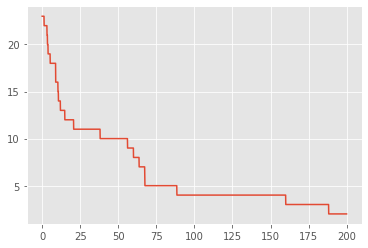

In [5]:
def choose_theta(maxtheta=200):
    y=[]
    x=np.arange(start=0.01,stop=maxtheta,step=0.1)
    for i in range(len(x)):
        hst.adjustingtheta(x[i]) 
        gs=GraphSignal(V,hst.snowweight,f)
        spa=SpectralAnalysis(gs)
        spa.graphFouriertransform()
        spa.decompose()        
        y.append(sum(abs(spa.lamb)<0.001))
    plt.plot(x,y)
choose_theta()   

In [6]:
hst.adjustingtheta(100)

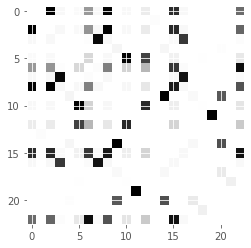

In [7]:
plt.imshow(hst.snowweight)

### R 환경으로..

In [8]:
import rpy2 
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython

In [9]:
n=hst.n 
V=hst.V
f=hst.f 
WEuclid= hst.euclidweight
Wgraph= (hst.graphweight+hst.graphweight.T)/2
Whst= hst.snowweight
W= hst.graphweight

In [10]:
%R -i n
%R -i V
%R -i f
%R -i WEuclid
%R -i Wgraph
%R -i Whst
%R -i W

### 유클리드와 그래프도메인의 정보를 플랏.

In [14]:
%%R 
source('heavysnow.R')
df<-tibble(V)
df$f<-as.vector(f)
df$divlink<-0
df$conlink<-0
df$link<-0
for(i in 1:23){
    df$divlink[i]<-sum(W[i,])
    df$conlink[i]<-sum(W[,i])
    df$link[i]<-(sum(W[i,])+sum(W[,i]))/2
}
df$movietype<-rep('singlehero',23)
df[V %in% c("The Avengers" ,"Avengers: Age of Ultron","Captain America: Civil War","Avengers: Infinity War","Avengers: Endgame"),'movietype']='multihero'
df

R[write to console]: Error in library(ggforce) : there is no package called ‘ggforce’



Error in library(ggforce) : there is no package called ‘ggforce’

In [12]:
%%R 
regular_grid=function(df,xyz){
    i=xyz[1]
    j=xyz[2]
    k=xyz[3]
    
    library(akima)
    library(reshape)
    fld <- with(df, interp(x = df[[i]], y = df[[j]], z = df[[k]]))
    # prepare data in long format
    df2 <- melt(fld$z, na.rm = TRUE)
    names(df2) <-c("x", "y", "z")
    df2$x <- fld$x[df2$x]
    df2$y <- fld$y[df2$y]
    names(df2) <- names(df)[c(i,j,k)]
    as_tibble(df2)
}
regular_grid(df,xyz=c(4,3,2))

R[write to console]: Error in library(akima) : there is no package called ‘akima’



Error in library(akima) : there is no package called ‘akima’

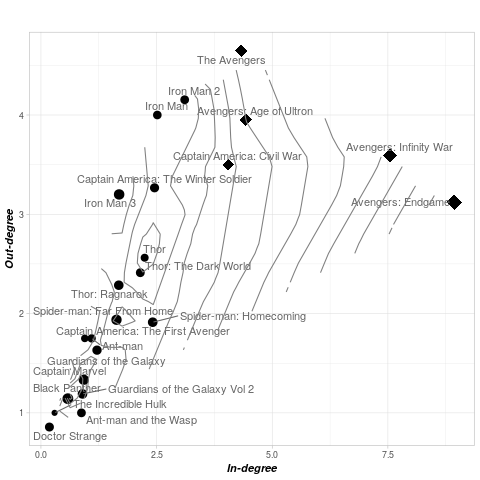

In [441]:
%%R 
#foo$location <- factor(foo$location, levels = c("Paris", "Madrid", "London"))
p1<-ggplot(df)+
    geom_point(aes(x=conlink,y=divlink,shape=movietype,size=f),stroke=2,fill='black')+
    scale_shape_manual(values=c(18,20))+
    theme_light()+
    geom_text_repel(aes(x=conlink,y=divlink,label=V),color="gray40")+
    #geom_density2d(data=.df,aes(x=conlink,y=divlink,fill=f),color="gray80",linetype = "dashed")+
    geom_contour(data=regular_grid(df,xyz=c(4,3,2)),aes(x=conlink,y=divlink,z=f),color='gray50',size=0.5)+
    ylab("Out-degree")+xlab("In-degree")+
    ggtitle("")+
    theme(plot.title=element_text(face="bold.italic",size=rel(2)))+
    theme(axis.title.x=element_text(face=4,size=rel(1)))+
    theme(axis.title.y=element_text(face=4,size=rel(1)))+
    theme(legend.position = "none")
show(p1)
ggsave(plot=p1,"./2021-12-10-p1.pdf",width=10,height=7)

### gfft 수행하고 결과를 저장함.

In [442]:
%%R 
g1<-gfft(f,WEuclid)
g2<-gfft(f,Wgraph)
g3<-gfft(f,Whst)

### 아이겐플랏

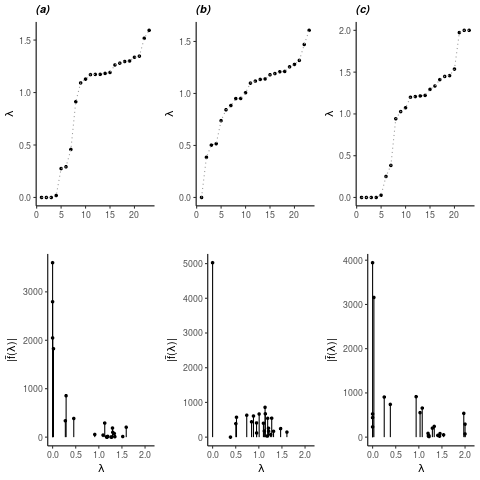

In [443]:
%%R 
library(gridExtra)
e1<-eigenplot(g1)+ggtitle("(a)")+theme(plot.title=element_text(face="bold.italic",size=rel(1)))
e2<-eigenplot(g2)+ggtitle("(b)")+theme(plot.title=element_text(face="bold.italic",size=rel(1)))
e3<-eigenplot(g3)+ggtitle("(c)")+theme(plot.title=element_text(face="bold.italic",size=rel(1)))
s1<-specplot(g1)
s2<-specplot(g2)
s3<-specplot(g3)
p2<-grid.arrange(e1,e2,e3,s1,s2,s3,nrow=2)
ggsave(plot=p2,"./2021-12-10-p2.pdf",width=5,height=3)

### 분해

In [444]:
%%R
d1<-decompose(f,WEuclid,V=V) # 0, 35000, 60000, 80000
d2<-decompose(f,Wgraph,V=V) # 0, 35000, 60000, 80000
d3<-decompose(f,Whst,V=V) # 0, 35000, 60000, 80000

d1$case<-"Euclid"
d2$case<-"Graph"
d3$case<-"HST"
.df2 <-rbind(d1,d2,d3)
.df2 %>% group_by(case,eigenvectorindex) #%>% mutate(textsize= 10*(abs(fhat)>70))
df2=merge(df, .df2 %>% group_by(case,eigenvectorindex) %>% mutate(textsize= 10*(abs(fhat)>70))) %>% as_tibble
df2

# A tibble: 1,587 × 12
   V          f divlink conlink  link movietype Vindex eigenvectorindex     fhat
   <chr>  <dbl>   <dbl>   <dbl> <dbl> <chr>      <int>            <dbl>    <dbl>
 1 Ant-m…  519.    1.75    1.10  1.42 singlehe…     12                1  561.   
 2 Ant-m…  519.    1.75    1.10  1.42 singlehe…     12                6 -142.   
 3 Ant-m…  519.    1.75    1.10  1.42 singlehe…     12               17   -1.52 
 4 Ant-m…  519.    1.75    1.10  1.42 singlehe…     12                5   61.6  
 5 Ant-m…  519.    1.75    1.10  1.42 singlehe…     12               12    0.274
 6 Ant-m…  519.    1.75    1.10  1.42 singlehe…     12               15    0.328
 7 Ant-m…  519.    1.75    1.10  1.42 singlehe…     12                8   28.4  
 8 Ant-m…  519.    1.75    1.10  1.42 singlehe…     12               22   -0.843
 9 Ant-m…  519.    1.75    1.10  1.42 singlehe…     12               18   -6.37 
10 Ant-m…  519.    1.75    1.10  1.42 singlehe…     12                2    4.86 
# … w

In [445]:
%%R 
df2

# A tibble: 1,587 × 12
   V          f divlink conlink  link movietype Vindex eigenvectorindex     fhat
   <chr>  <dbl>   <dbl>   <dbl> <dbl> <chr>      <int>            <dbl>    <dbl>
 1 Ant-m…  519.    1.75    1.10  1.42 singlehe…     12                1  561.   
 2 Ant-m…  519.    1.75    1.10  1.42 singlehe…     12                6 -142.   
 3 Ant-m…  519.    1.75    1.10  1.42 singlehe…     12               17   -1.52 
 4 Ant-m…  519.    1.75    1.10  1.42 singlehe…     12                5   61.6  
 5 Ant-m…  519.    1.75    1.10  1.42 singlehe…     12               12    0.274
 6 Ant-m…  519.    1.75    1.10  1.42 singlehe…     12               15    0.328
 7 Ant-m…  519.    1.75    1.10  1.42 singlehe…     12                8   28.4  
 8 Ant-m…  519.    1.75    1.10  1.42 singlehe…     12               22   -0.843
 9 Ant-m…  519.    1.75    1.10  1.42 singlehe…     12               18   -6.37 
10 Ant-m…  519.    1.75    1.10  1.42 singlehe…     12                2    4.86 
# … w

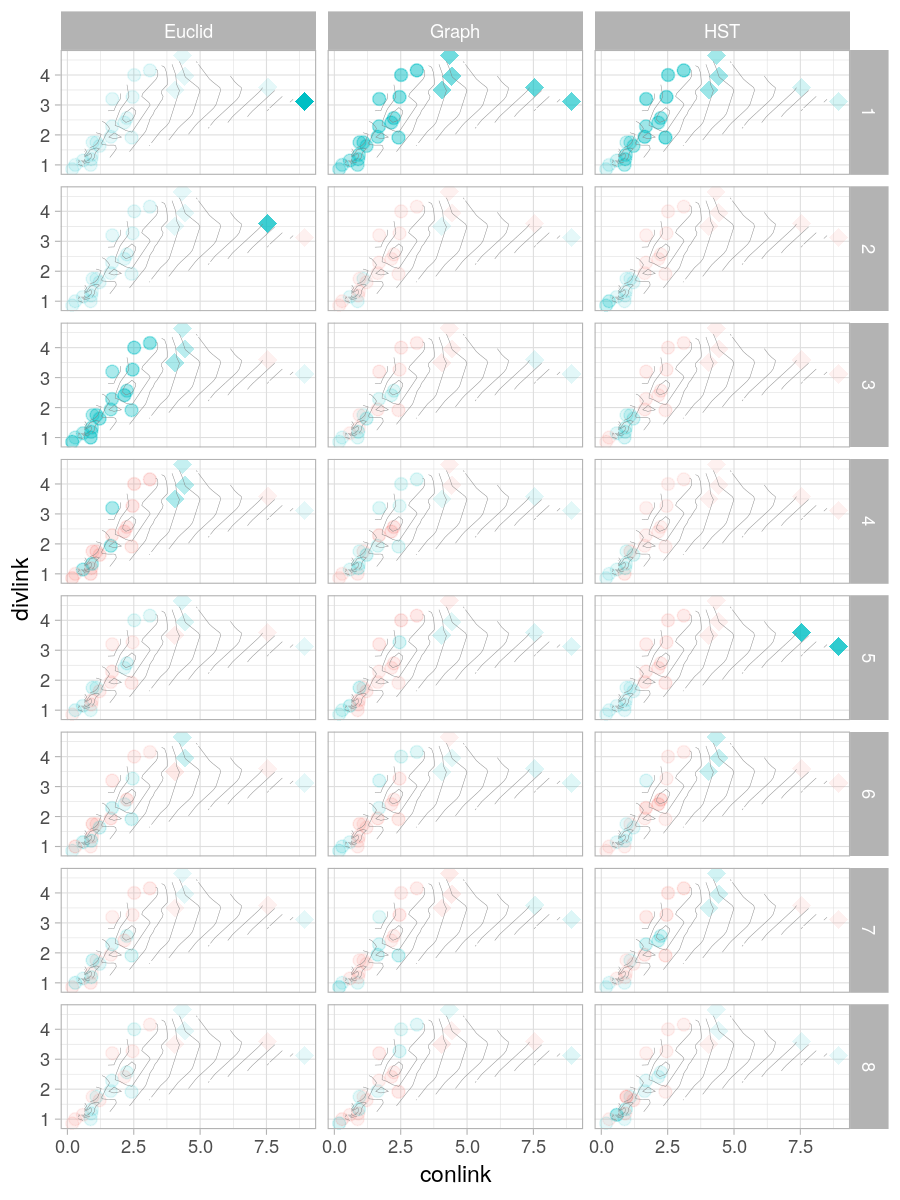

In [446]:
%%R -r 150 -w 900 -h 1200
p3 <- ggplot(data=filter(df2,eigenvectorindex %in% 1:8))+
    geom_point(aes(x=conlink,y=divlink,alpha=abs(fhat),shape=movietype,color=(fhat>0)),size=4)+
    #geom_density2d(data=.df,aes(x=conlink,y=divlink),size=0.2,color="gray80",linetype = "dashed")+
    geom_contour(data=regular_grid(df,xyz=c(4,3,2)),aes(x=conlink,y=divlink,z=f),color='gray50',size=0.1)+
    scale_shape_manual(values=c(18,20))+
    theme_light()+
    facet_grid(eigenvectorindex~case)+
    theme(legend.position="none")
show(p3)

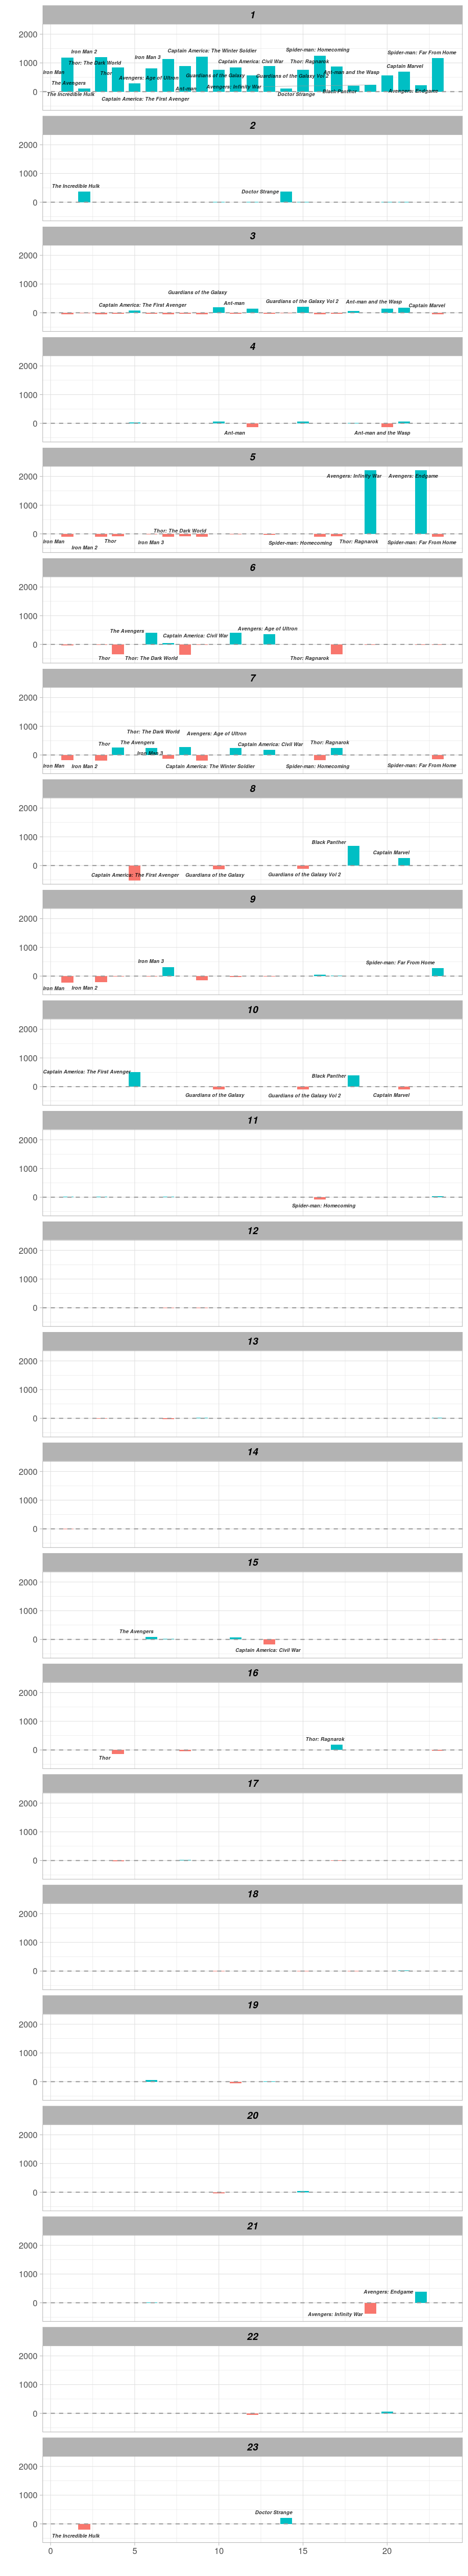

In [447]:
%%R -r 150 -w 1000 -h 5500
        
p3<-ggplot(data=filter(df2, case=='HST',eigenvectorindex %in% 1:23))+
    geom_col(aes(x=Vindex,y=fhat,fill=fhat>0),width=0.7)+
    geom_text_repel(aes(x=Vindex,y=fhat,label=V,size=textsize),col=1,fontface=4,alpha=0.8,segment.size=0.2,segment.color="gray60",min.segment.length=5,hjust=0.1)+
    scale_radius(range = c(0,1.8))+
    guides(size=FALSE)+
    facet_wrap('eigenvectorindex',ncol=1)+
    geom_hline(aes(yintercept=0),col="gray60",lty=2)+
    xlab("")+ylab("")+guides(fill=FALSE)+
    theme(axis.text.x=element_text(angle=85,hjust=1,vjust=1,face=4,size=rel(0.7),colour="gray60"))+
    theme_light()+
    theme(strip.text.x = element_text(size = 10, color = "black", face = "bold.italic"))+
    theme(strip.text.y = element_text(size = 10, color = "black", face = "bold.italic"))+
    theme(plot.title=element_text(face="bold.italic",size=rel(1.5)))
show(p3)

#ggsave(plot=p3,"./fig/p3.pdf",width=6,height=6)

In [430]:
%%R
dat3_Euclid <- decomp_dat %>% filter(case=="Euclid",eigenvectorindex==1) %>% select(V,case,eigenvectorindex,textsize,fhat)
dat3_Euclid <- left_join(dat,dat3_Euclid,by="V")

for(j in 2:23){
        decomp_filtered_dat_<- decomp_dat %>% filter(case=="Euclid",eigenvectorindex==j) %>% select(V,case,eigenvectorindex,textsize,fhat)
        decomp_filtered_dat_<- left_join(dat,decomp_filtered_dat_,by="V")
        dat3_Euclid<-rbind(dat3_Euclid,decomp_filtered_dat_)
}

dat3_Graph <- decomp_dat %>% filter(case=="Graph",eigenvectorindex==1) %>% select(V,case,eigenvectorindex,textsize,fhat)
dat3_Graph <- left_join(dat,dat3_Graph,by="V")

for(j in 2:23){
        decomp_filtered_dat_<- decomp_dat %>% filter(case=="Graph",eigenvectorindex==j) %>% select(V,case,eigenvectorindex,textsize,fhat)
        decomp_filtered_dat_<- left_join(dat,decomp_filtered_dat_,by="V")
        dat3_Graph<-rbind(dat3_Graph,decomp_filtered_dat_)
}

dat3_HST <- decomp_dat %>% filter(case=="HST",eigenvectorindex==1) %>% select(V,case,eigenvectorindex,textsize,fhat)
dat3_HST <- left_join(dat,dat3_HST,by="V")

for(j in 2:23){
        decomp_filtered_dat_<- decomp_dat %>% filter(case=="HST",eigenvectorindex==j) %>% select(V,case,eigenvectorindex,textsize,fhat)
        decomp_filtered_dat_<- left_join(dat,decomp_filtered_dat_,by="V")
        dat3_HST<-rbind(dat3_HST,decomp_filtered_dat_)
}
dat3<-rbind(dat3_Euclid,dat3_Graph,dat3_HST)

R[write to console]: Error in filter(., case == "Euclid", eigenvectorindex == 1) : 
  object 'decomp_dat' not found

R[write to console]: In addition: 
R[write to console]: There were 50 or more warnings (use warnings() to see the first 50)
R[write to console]: 



Error in filter(., case == "Euclid", eigenvectorindex == 1) : 
  object 'decomp_dat' not found

In [ ]:
%%R -r 300 -w 2000 -h 3000
hull_cyl <- dat3 %>%
            group_by(case,eigenvectorindex) %>% 
            filter(textsize>0) %>% 
            slice(chull(f, divlink))
p4<-ggplot(dat3%>% filter(eigenvectorindex<8))+geom_point(aes(x=f,y=divlink,col=textsize>0,size=fhat*(fhat>0)),alpha=0.8)+
        geom_shape(data=hull_cyl%>% filter(eigenvectorindex<8) ,aes(x=f,y=divlink),alpha=0.05,col="gray30",radius=0.05,expand=0.05)+
        facet_grid(eigenvectorindex~case)+
        scale_size_continuous(range=c(2,2.5))+
        scale_color_manual(values=c("gray80", "gray20"))+
        ylim(0,8)+xlim(0,3000)+
        guides(alpha=F)+
        guides(col=F)+
        guides(size=F)+
        ylab("")+xlab("")+
        geom_hline(aes(yintercept=2),col="gray30",lty=2,lwd=0.2)+
        geom_vline(aes(xintercept=1000),col="gray30",lty=2,lwd=0.2)+
        theme_light()+
        theme(strip.text.x = element_text(size = 10, color = "black", face = "bold.italic"))+
        theme(strip.text.y = element_text(size = 10, color = "black", face = "bold.italic"))+
        theme(plot.title=element_text(face="bold.italic",size=rel(1.5)))
show(p4)
#ggsave(plot=p4,"./fig/p4.pdf",width=7,height=7)

In [ ]:
%%R -r 300 -w 2000 -h 3000
hull_cyl <- dat3 %>%
            group_by(case,eigenvectorindex) %>% 
            filter(textsize>0) %>% 
            slice(chull(f, conlink))
p5<-ggplot(dat3%>% filter(eigenvectorindex<8))+geom_point(aes(x=f,y=conlink,col=textsize>0,size=fhat*(fhat>0)),alpha=0.8)+
        geom_shape(data=hull_cyl%>% filter(eigenvectorindex<8) ,aes(x=f,y=conlink),alpha=0.05,col="gray30",radius=0.05,expand=0.05)+
        facet_grid(eigenvectorindex~case)+
        scale_size_continuous(range=c(2,2.5))+
        scale_color_manual(values=c("gray80", "gray20"))+        
        ylim(0,10)+xlim(0,3000)+
        guides(col=F)+
        guides(alpha=F)+
        guides(size=F)+       
        ylab("")+xlab("")+
        geom_hline(aes(yintercept=3.75),col="gray30",lty=2,lwd=0.2)+
        geom_vline(aes(xintercept=1000),col="gray30",lty=2,lwd=0.2)+
        theme_light()+
        theme(strip.text.x = element_text(size = 10, color = "black", face = "bold.italic"))+
        theme(strip.text.y = element_text(size = 10, color = "black", face = "bold.italic"))+
        theme(plot.title=element_text(face="bold.italic",size=rel(1.5)))
show(p5)
#ggsave(plot=p5,"./fig/p5.pdf",width=7,height=7)        

In [ ]:
%%R -r 300 -w 2000 -h 1500
p_<-grid.arrange(p4,p5,ncol=2)
#ggsave(plot=p6,"./fig/p6.pdf",width=10,height=12)

In [ ]:
%%R -r 200 -w 2000 -h 3000
p6<-grid.arrange(p1,p_,nrow=2,heights=c(3,5))

In [ ]:
%run heavysnow 
gs=GraphSignal(V,hst.snowweight,f)
spa=SpectralAnalysis(gs)

In [ ]:
spa.n

In [ ]:
spa.graphFouriertransform()
spa.decompose()

In [ ]:
spa.V

In [ ]:
df=pd.DataFrame(spa.components)
df

In [ ]:
df=df.stack().reset_index().rename(columns={'level_0':'vertex','level_1':'comp',0:'fhat'})

In [ ]:
df 

In [ ]:
df['fill']= df.fhat >0 

In [ ]:
df

In [ ]:
n=23
fig=ggplot(df)
facet=facet_wrap('comp',ncol=1)
aes1=aes(x='vertex',y='fhat',fill='fill')
aes3=aes(x='vertex',y='fhat',label=spa.V)
geom1=geom_col(aes1,alpha=0.8)
geom2=geom_hline(yintercept = 0,linetype='dashed',color='gray',size=0.3)
#geom3=geom_text_repel(aes(x=Vindex,y=fhat,label=V)

In [ ]:
fig+facet+geom1+geom2+xlab("")+ylab("")+theme(figure_size=(3, 3*n))+theme(legend_position="none")